# __Machine Learning for Prioritizing Blood Pressure Genes__ 

In [84]:
import re

import numpy as np
import pandas as pd
from numpy import sort

regex = re.compile(r"\[|\]|<", re.IGNORECASE)

import seaborn as sns
import shap
import statsmodels.api as sm

%matplotlib inline
%config InlineBackend.figure_format ='retina'
import statsmodels.stats.api as sms

from sklearn import datasets, metrics, model_selection, preprocessing
import catboost
from catboost import CatBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from missingpy import MissForest
from sklearn.metrics import (
    explained_variance_score,
    max_error,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
)
from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    RandomizedSearchCV,
    RepeatedKFold,
    cross_val_predict,
    cross_val_score,
    cross_validate,
    learning_curve,
    train_test_split,
    validation_curve,
)

sns.set_style("darkgrid")
sns.mpl.rcParams["figure.figsize"] = (15.0, 9.0)

import warnings

import matplotlib
import matplotlib.pyplot as plt

warnings.simplefilter(action="ignore", category=FutureWarning)
from warnings import filterwarnings

filterwarnings("ignore")

seed = 0

In [85]:
data = pd.read_csv("training_cleaned.csv", header=0, sep=",")

In [86]:
data["BPlabel_encoded"] = data["BPlabel"].map(
    {"most likely": 1, "probable": 0.75, "least likely": 0.1}
)
Y = data["BPlabel_encoded"]
data = data.drop(["BPlabel"], 1)
data.shape

(293, 60)

### Load Boruta Shap Selected Features

In [87]:
X_boruta_sel = pd.read_csv("selected_features_training_data.csv", header=0)
X_boruta_sel.columns = [
    regex.sub("_", col) if any(x in str(col) for x in set(("[", "]", "<"))) else col
    for col in X_boruta_sel.columns.values
]



In [88]:
df_gene = data[["Gene"]]

X_boruta_sel = pd.concat([df_gene, X_boruta_sel], axis=1)

X_boruta_sel = X_boruta_sel.set_index("Gene")

In [89]:
X_train_borsel, X_test_borsel, Y_train_borsel, Y_test_borsel = train_test_split(
    X_boruta_sel, Y, test_size=0.2, random_state=0
)

### Optimized Model:
- cb (gradient boosting regression) model with set parameters used for the rest of the code

In [90]:
cb = CatBoostRegressor(depth=4, iterations=50, learning_rate=0.2, random_seed=seed, verbose=False)


### Training Data Prediction Visualization:

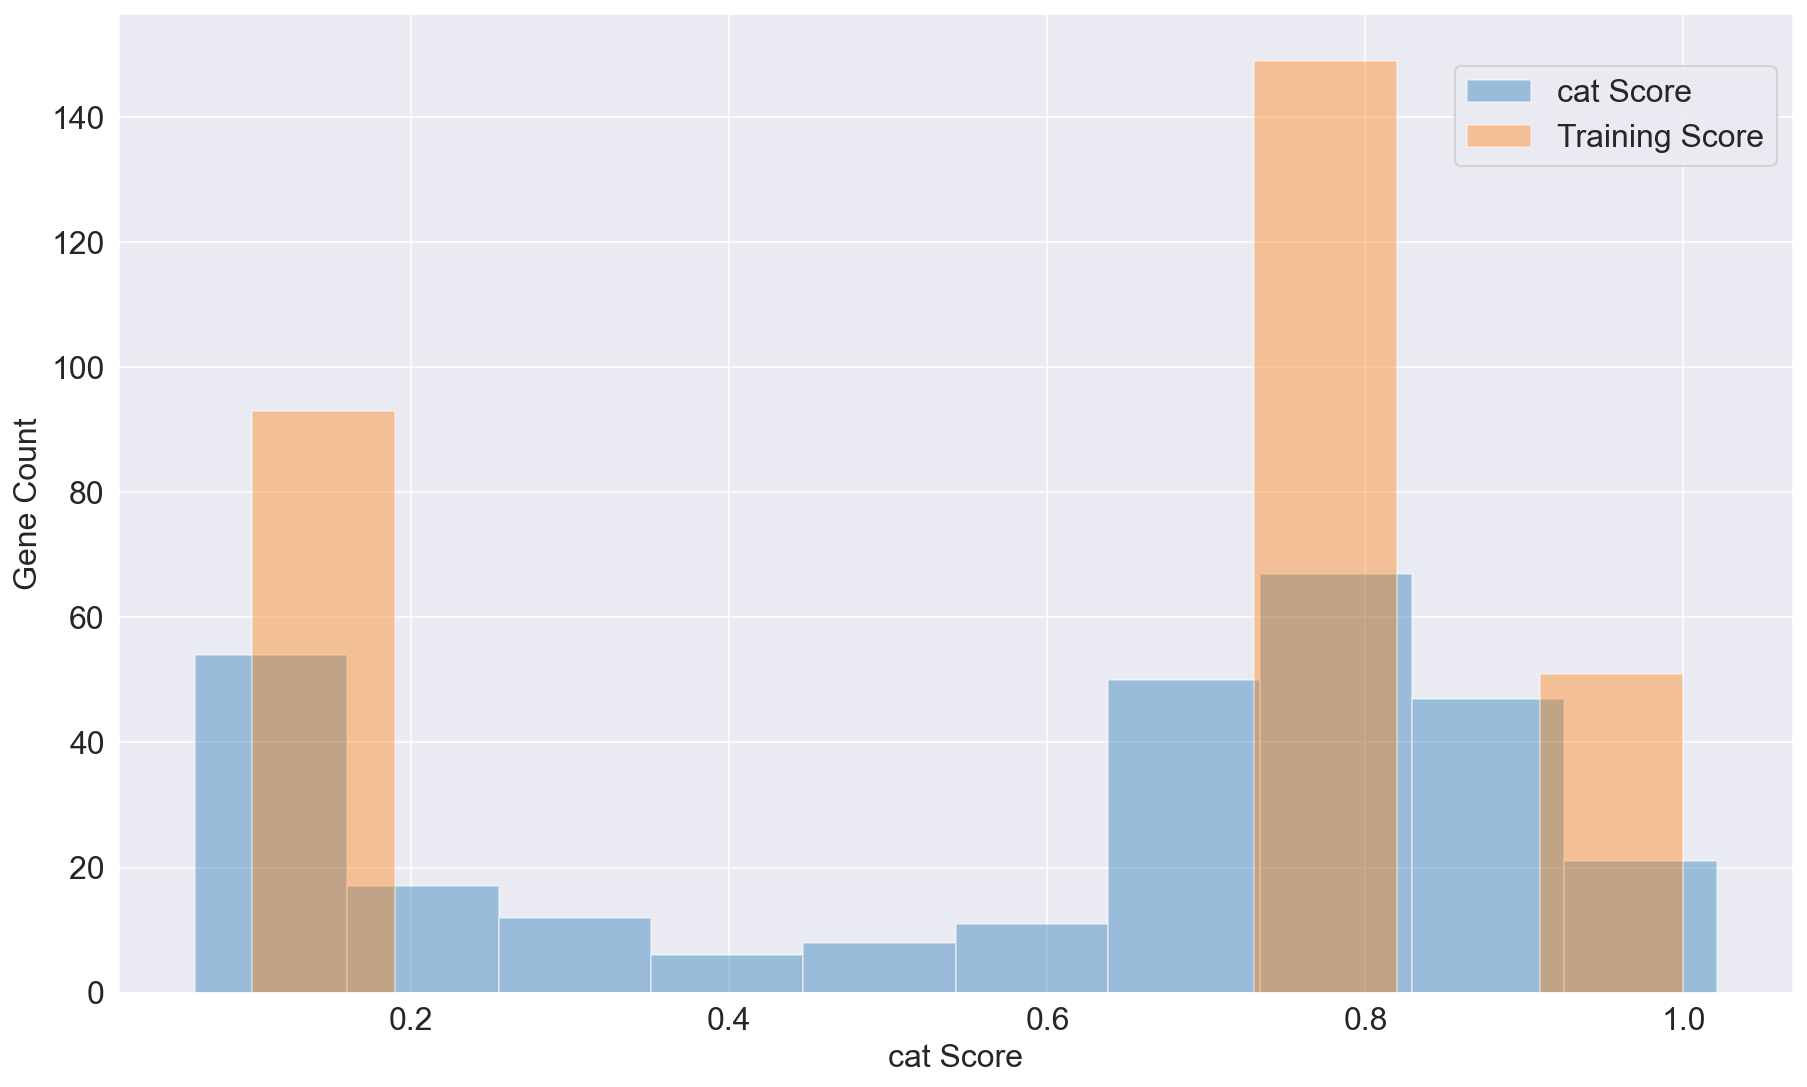

In [91]:
cb.fit(X_train_borsel, Y_train_borsel)
predictions = list(cb.predict(X_boruta_sel))

output = pd.Series(data=predictions, index=X_boruta_sel.index, name="cat_Score")

df_total_training = pd.concat([X_boruta_sel, output], axis=1)

df_total = pd.concat([X_boruta_sel, output], axis=1)

fig, ax = plt.subplots()

sns.distplot(df_total["cat_Score"], ax=ax, kde=False, norm_hist=False, bins=10)
sns.distplot(Y, ax=ax, kde=False, bins=10)
fig.legend(
    labels=["cat Score", "Training Score"],
    loc="upper right",
    bbox_to_anchor=(0.83, 0.8),
    ncol=1,
    fontsize=16,
)
ax.set_xlabel("cat Score", fontsize=16)
ax.set_ylabel("Gene Count", fontsize=16)
ax.tick_params(labelsize=16)

In [92]:
predictions = list(cb.predict(X_boruta_sel))

output = pd.Series(data=predictions, index=X_boruta_sel.index, name="cb_Score")

output = output.to_frame()
output.reset_index(level=0, inplace=True)

In [93]:
df_b = data[["BPlabel_encoded"]]

df_c = pd.concat([output, df_b], axis=1)

df_c.to_csv("cat_training_evangelou.csv", index=False)

df_c

,Gene,cb_Score,BPlabel_encoded
0,ABCC9,1.014719,1.00
1,AC006455.1,0.134839,0.10
2,AC007216.2,0.173056,0.10
3,AC007461.1,0.124007,0.10
4,AC008498.1,0.120088,0.10
...,...,...,...
288,YES1,0.794383,0.75
289,Z98049.1,0.117713,0.10
290,ZAP70,0.717278,0.75
291,ZMYM6NB,0.124042,0.10


## Overview of SHAP feature importance:
- Further invesitgation into SHAP visualization of training data continued in the next script (SHAP_Random-Forest-BPGWASPredict.ipynb)

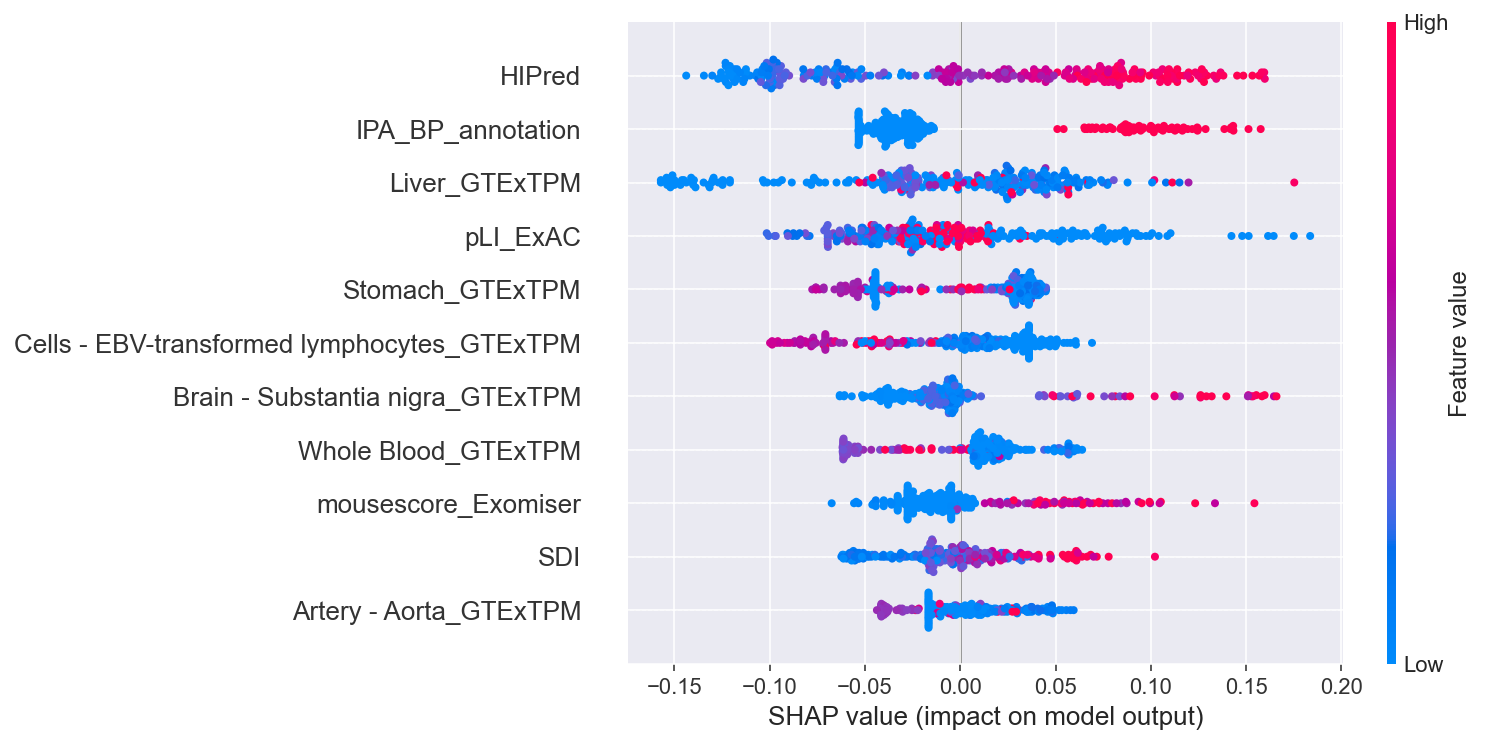

In [94]:
cb.fit(X_boruta_sel, Y)
df3 = pd.DataFrame(data=X_boruta_sel, columns=X_boruta_sel.columns)
df3.columns = [
    regex.sub("_", col) if any(x in str(col) for x in set(("[", "]", "<"))) else col
    for col in X_boruta_sel.columns.values
]
X_importance = X_boruta_sel
explainer = shap.TreeExplainer(cb)
shap_values = explainer.shap_values(X_importance)
X_importance = pd.DataFrame(data=X_boruta_sel, columns=df3.columns)
shap.summary_plot(shap_values, X_importance)

In [95]:
X_boruta_sel.columns

Index(['Stomach_GTExTPM', 'mousescore_Exomiser',
       'Brain - Substantia nigra_GTExTPM', 'Artery - Aorta_GTExTPM', 'SDI',
       'HIPred', 'Whole Blood_GTExTPM', 'IPA_BP_annotation',
       'Cells - EBV-transformed lymphocytes_GTExTPM', 'Liver_GTExTPM',
       'pLI_ExAC'],
      dtype='object')

### Unknown gene prediction by the trained model:

In [96]:
dataset_unknown = pd.read_csv("BP_unknown.txt", sep="\t")
dataset_unknown = dataset_unknown.rename({'IPA_BP':'IPA_BP_annotation'}, axis=1)
df2 = dataset_unknown[
    ['Stomach_GTExTPM', 'mousescore_Exomiser',
       'Brain - Substantia nigra_GTExTPM', 'Artery - Aorta_GTExTPM', 'SDI',
       'HIPred', 'Whole Blood_GTExTPM', 'IPA_BP_annotation',
       'Cells - EBV-transformed lymphocytes_GTExTPM', 'Liver_GTExTPM',
       'pLI_ExAC'
    ]
]

df2.shape

(1804, 11)

In [97]:
imputer = MissForest(random_state=seed)
df3 = imputer.fit_transform(df2)

Iteration: 0
Iteration: 1
Iteration: 2


In [98]:
X2 = pd.DataFrame(df3, index=df2.index, columns=df2.columns)
X2.shape

(1804, 11)

In [99]:
model = cb
model.fit(X_boruta_sel, Y)
predictions = list(model.predict(X2))

output = pd.Series(data=predictions, index=dataset_unknown.index, name="cb_Score")

df_total = pd.concat([dataset_unknown, output], axis=1)

In [100]:
df_total.nlargest(10, "cb_Score", keep="last")

,Gene,REVEL.max,MetaSVM_rankscore.max,MetaLR_rankscore.max,MCAP.max,wgEncodeBroadHmmHuvecHMM.count,betamax,logpval_gwascatalog,Adipose - Subcutaneous_GTExTPM,Adipose - Visceral (Omentum)_GTExTPM,...,MetaLR_rankscore,MetaSVM_rankscore,MutationAssessor_rankscore,REVEL_score,fathmm-MKL_coding_score,integrated_fitCons_rankscore,LoFtool,GERP_Rankscore,BPlabel,cb_Score
827,MLIP,0.000,0.354,0.075,NaN,10,-0.1964,13.000000,0.673251,0.293427,...,0.48084,0.63282,0.97045,0.508,0.98749,0.97801,0.2800,0.81769,unknown,1.046488
46,ACMSD,NaN,NaN,NaN,NaN,39,-0.3064,13.221849,0.035258,0.024026,...,NaN,NaN,NaN,NaN,NaN,NaN,0.5940,NaN,unknown,0.986431
306,CHRM2,NaN,NaN,NaN,NaN,494,0.4323,12.000000,0.004196,0.023050,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unknown,0.973915
100,APOH,0.757,0.880,0.976,NaN,646,-0.3513,430.154902,0.000000,0.063187,...,0.63992,0.67781,0.61577,0.248,0.95181,0.61202,0.5870,0.68106,unknown,0.949868
716,KLF2,0.092,0.068,0.000,NaN,30,-0.2679,11.000000,224.379000,182.694000,...,NaN,NaN,NaN,NaN,NaN,NaN,0.2690,NaN,unknown,0.947120
114,ARHGEF26,0.456,0.792,0.653,NaN,222,0.6269,10.000000,10.389700,7.280710,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unknown,0.939929
1444,SGCD,NaN,NaN,NaN,NaN,280,0.2110,10.000000,3.075140,2.000780,...,NaN,NaN,NaN,NaN,NaN,NaN,0.2760,NaN,unknown,0.939216
1569,SYNE1,0.408,0.843,0.828,NaN,338,-0.2575,53.698970,11.143400,9.964200,...,0.85482,0.84714,0.67893,0.584,0.98760,0.44609,0.8850,0.83298,unknown,0.939074
678,INSR,NaN,NaN,NaN,NaN,36,0.4094,58.000000,21.887400,21.162300,...,0.91507,0.87840,0.82663,0.553,0.95985,0.83141,0.0375,0.66477,unknown,0.931345
1172,PTPRD,0.063,0.074,0.129,NaN,21,-0.5182,41.154902,2.011080,2.584140,...,0.12892,0.07407,0.16088,0.063,0.88634,0.56070,0.0868,0.61880,unknown,0.921486


In [102]:
inter = df_total[
    ['Gene','cb_Score','Stomach_GTExTPM', 'mousescore_Exomiser',
       'Brain - Substantia nigra_GTExTPM', 'Artery - Aorta_GTExTPM', 'SDI',
       'HIPred', 'Whole Blood_GTExTPM', 'IPA_BP_annotation',
       'Cells - EBV-transformed lymphocytes_GTExTPM', 'Liver_GTExTPM',
       'pLI_ExAC'
    ]
]

X3 = pd.read_csv("selected_features_training_data.csv", header=0)

df_train = pd.concat([df_c, X3], axis=1)


In [108]:
df_train.shape

(293, 14)

In [106]:
df_train.to_csv("train_gene_scores.csv", index=False)

In [107]:
inter.to_csv("unknown_gene_scores.csv", index=False)

In [54]:
df10 = df_total.nlargest(10, "cat_Score", keep="last")
df10.to_csv("Top10Genes.csv", index=False)

In [55]:
df10 = df_total.nlargest(10, "cat_Score", keep="last")
df10 = df10[[
    "Gene",
'Stomach_GTExTPM', 'mousescore_Exomiser',
       'Brain - Substantia nigra_GTExTPM', 'Artery - Aorta_GTExTPM', 'SDI',
       'HIPred', 'Whole Blood_GTExTPM', 'IPA_BP_annotation',
       'Cells - EBV-transformed lymphocytes_GTExTPM', 'Liver_GTExTPM',
       'pLI_ExAC']]

df10.to_csv("Top10Genes_SelectedFeatures.csv", index=False)

In [57]:
df_file = df_total[["Gene", "cat_Score"]]
df_file = df_file.nlargest(1804, "cat_Score", keep="last")
df_file.to_csv("BPgene_ranking_cat_evangelou.txt", index=False)

### Overview of SHAP feature importance:

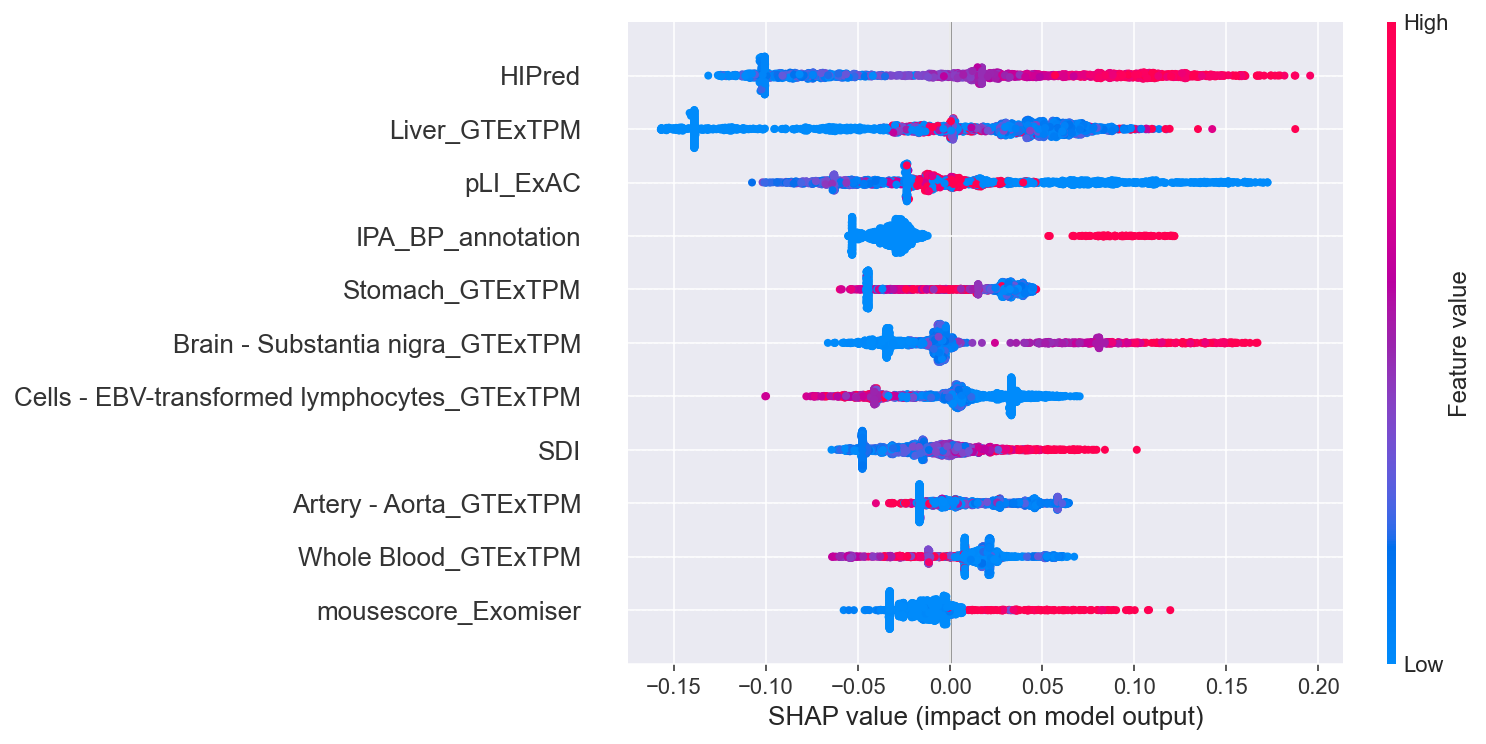

In [58]:
df3 = pd.DataFrame(data=X2, columns=X2.columns)
df3.columns = [
    regex.sub("_", col) if any(x in str(col) for x in set(("[", "]", "<"))) else col
    for col in X_boruta_sel.columns.values
]
X_importance = X2
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_importance)
X_importance = pd.DataFrame(data=X2, columns=df3.columns)
shap.summary_plot(shap_values, X_importance)